<a href="https://colab.research.google.com/github/mkschulz9/fine-tuning-stable-diffusion-3/blob/main/csci_566_lora_checkpoint_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Colab notebook documents how to load a checkpont for an SD3 model that has been lora fine-tuned with the JasperAI FlashSD3 pipeline

# Load Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Unzipping file


In [ ]:
!gunzip -k /content/drive/MyDrive/566/ft_650_iters/step650.ckpt.gz

# Install Dependencies

In [ ]:
!pip install git+https://github.com/initml/diffusers.git@clement/feature/flash_sd3

  Cloning https://github.com/initml/diffusers.git (to revision clement/feature/flash_sd3) to /tmp/pip-req-build-8dl1u_rz
  Running command git clone --filter=blob:none --quiet https://github.com/initml/diffusers.git /tmp/pip-req-build-8dl1u_rz
  Running command git checkout -b clement/feature/flash_sd3 --track origin/clement/feature/flash_sd3
  Switched to a new branch 'clement/feature/flash_sd3'
  Branch 'clement/feature/flash_sd3' set up to track remote branch 'clement/feature/flash_sd3' from 'origin'.
  Resolved https://github.com/initml/diffusers.git to commit 53dcfcf3f3009a79fd484eed9b09ea76189da434
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.29.0.dev0-py3-none-any.whl size=2217663 sha256=fd2370fb0b459e1aaf8fec35f04033b048d0ed9c57b2847532ce5c9894e8299e
  Stored in directory: /tmp/pip-ephem-wheel-cache-zbhttn6l/wheels/75/20/57/ce6698a32fcf2a

In [ ]:
!git clone https://github.com/gojasper/flash-diffusion.git

Cloning into 'flash-diffusion'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 188 (delta 27), reused 58 (delta 22), pack-reused 123 (from 1)
Receiving objects: 100% (188/188), 51.60 MiB | 22.15 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [ ]:
!pip install -r /content/flash-diffusion/requirements.txt
!pip install -e /content/flash-diffusion/.

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
  Cloning https://github.com/initml/diffusers.git (to revision clement/feature/flash) to /tmp/pip-install-nnvag0m3/diffusers_682045a1ec00481c9a88bb1f5278b9f0
  Running command git clone --filter=blob:none --quiet https://github.com/initml/diffusers.git /tmp/pip-install-nnvag0m3/diffusers_682045a1ec00481c9a88bb1f5278b9f0
  Running command git checkout -b clement/feature/flash --track origin/clement/feature/flash
  Switched to a new branch 'clement/feature/flash'
  Branch 'clement/feature/flash' set up to track remote branch 'clement/feature/flash' from 'origin'.
  Resolved https://github.com/initml/diffusers.git to commit 04bb8ffc1df6dd85427e2508fd8582a57e984787
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.7/811.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import sys
sys.path.append('/content/flash-diffusion/src')

# Load Checkpoint and Save Tensor

In [ ]:
import torch
checkpoint = torch.load("/content/drive/MyDrive/566/ft_1250_iters/step1250.ckpt", map_location=torch.device('cpu'))


In [ ]:
state_dict = checkpoint["state_dict"]

In [ ]:
student_weights = {k: v for k, v in state_dict.items() if "student_denoiser" in k}

In [ ]:
len(student_weights)

1127

In [ ]:
from safetensors.torch import save_file

# Save filtered weights as `.safetensors`
safetensors_path = "/content/drive/MyDrive/566/ft_1250_iters/adapter_model.safetensors"
save_file(student_weights, safetensors_path)

print(f"LoRA weights saved to {safetensors_path}")


LoRA weights saved to /content/drive/MyDrive/566/ft_1250_iters/adapter_model.safetensors


# Create Pipeline for Inferencing

In [ ]:
from flash.models.flash.flash_diffusion_model import FlashDiffusion
print(FlashDiffusion)

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


<class 'flash.models.flash.flash_diffusion_model.FlashDiffusion'>


In [ ]:
from flash.models.flash_sd3 import FlashDiffusionSD3, FlashDiffusionSD3Config
from flash.models.transformers import DiffusersSD3Transformer2DWrapper

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
from diffusers import StableDiffusion3Pipeline, SD3Transformer2DModel, FlashFlowMatchEulerDiscreteScheduler
from peft import PeftModel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [ ]:
transformer = SD3Transformer2DModel.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    subfolder="transformer",
    torch_dtype=torch.float16,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


transformer/config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.17G [00:00<?, ?B/s]

In [ ]:
transformer = PeftModel.from_pretrained(transformer, "/content/drive/MyDrive/566/ft_1250_iters")


In [ ]:
# Pipeline
pipe = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    transformer=transformer,
    torch_dtype=torch.float16,
    text_encoder_3=None,
    tokenizer_3=None
)

model_index.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/247M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/739 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
pipe.scheduler = FlashFlowMatchEulerDiscreteScheduler.from_pretrained(
  "stabilityai/stable-diffusion-3-medium-diffusers",
  subfolder="scheduler",
)

pipe.to("cuda")

StableDiffusion3Pipeline {
  "_class_name": "StableDiffusion3Pipeline",
  "_diffusers_version": "0.29.0.dev0",
  "_name_or_path": "stabilityai/stable-diffusion-3-medium-diffusers",
  "scheduler": [
    "diffusers",
    "FlashFlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_3": [
    null,
    null
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_3": [
    null,
    null
  ],
  "transformer": [
    "diffusers",
    "SD3Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
prompt = 'A Basic Pokemon Card of type Water with the title Mantine and 110 HP of rarity Common from the set Astral Radiance and the flavor text: This calm and gentle Pokemon swims gracefully through the sea.'


  0%|          | 0/24 [00:00<?, ?it/s]

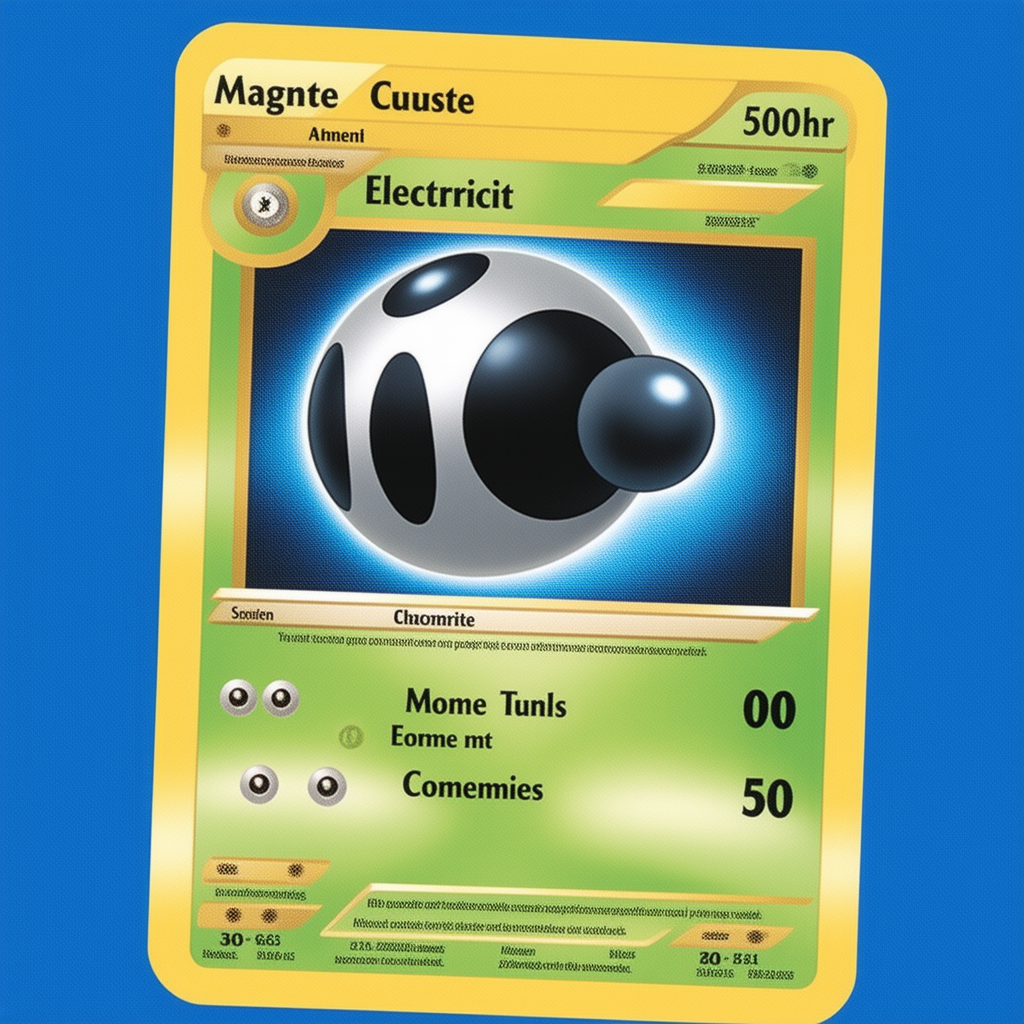

In [ ]:
image = pipe(prompt, num_inference_steps=4, guidance_scale=0).images[0]
display(image)
